In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,  LabelEncoder
from pprint import pprint
from sklearn.metrics import confusion_matrix, roc_curve, auc
from google.colab import drive

Loading the Data directly from upload

In [ ]:
intel_df , amd_df = pd.read_csv('/content/INTELpartialspecs_adjusted.csv'),pd.read_csv('/content/AMDfullspecs_adjusted.csv')

In [ ]:
print(intel_df.columns)
print(amd_df.columns)

Index(['product', 'releaseDate', 'cores', 'threads', 'maxTurboClock',
       'baseClock', 'cache', 'cacheInfo', 'TDP', 'lith', 'status',
       'integratedG'],
      dtype='object')
Index(['model', 'launchDate', 'numCores', 'numThreads', 'baseClock',
       'maxboostClock', 'allCoreBoostSpeed', 'L1Cache', 'L2Cache', 'L3Cache',
       'processTech', 'PCIeVersion', 'PCIeLanes', 'defaultTDP', 'configTDP',
       'tjMax', 'sysMemType', 'sysMemSpecs', 'memChannels', 'perSocketMemBW',
       'graphicsCores', 'graphicsFreq', 'unlocked', 'platform', 'cpuSocket',
       'socketCount', 'family', 'line', 'graphicsModel', 'thermalSolution'],
      dtype='object')


In [ ]:
amd_df = amd_df.rename(columns={'model': 'product',
                                'launchDate': 'releaseDate',
                                'numThreads': 'threads',
                                'numCores':"cores" ,
                                "L1Cache":'cache',
                                "defaultTDP":"TDP" ,

                                })

amd_df = amd_df[['product','releaseDate','threads','cores','baseClock','cache','TDP']]
intel_df = intel_df[['product','releaseDate','threads','cores','baseClock','cache','TDP']].dropna()

In [ ]:
amd_df['product'].nunique()

569

In [ ]:
intel_df['product'].nunique()

867

In [ ]:
amd_df.isna().sum()

product          0
releaseDate    321
threads         60
cores            5
baseClock        0
cache          259
TDP              8
dtype: int64

In [ ]:
amd_df.fillna(amd_df.mean(numeric_only  = True),inplace = True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
amd_df['target'] = 'AMD'
intel_df['target'] = 'INTEL'

merged  = pd.concat([amd_df, intel_df], ignore_index = True)
merged.shape

In [ ]:
merged.to_csv('FULL_MERGED_PROCESSORS.csv', index = False)

## EXPLORATORY DATA ANALYSIS (EDA)

<Axes: xlabel='target', ylabel='count'>

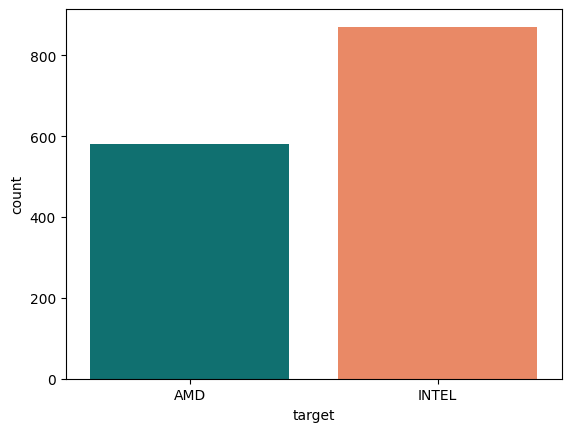

In [ ]:
sns.countplot(x = 'target', hue = 'target',data = merged, palette = ['#008080', '#FF7F50'])

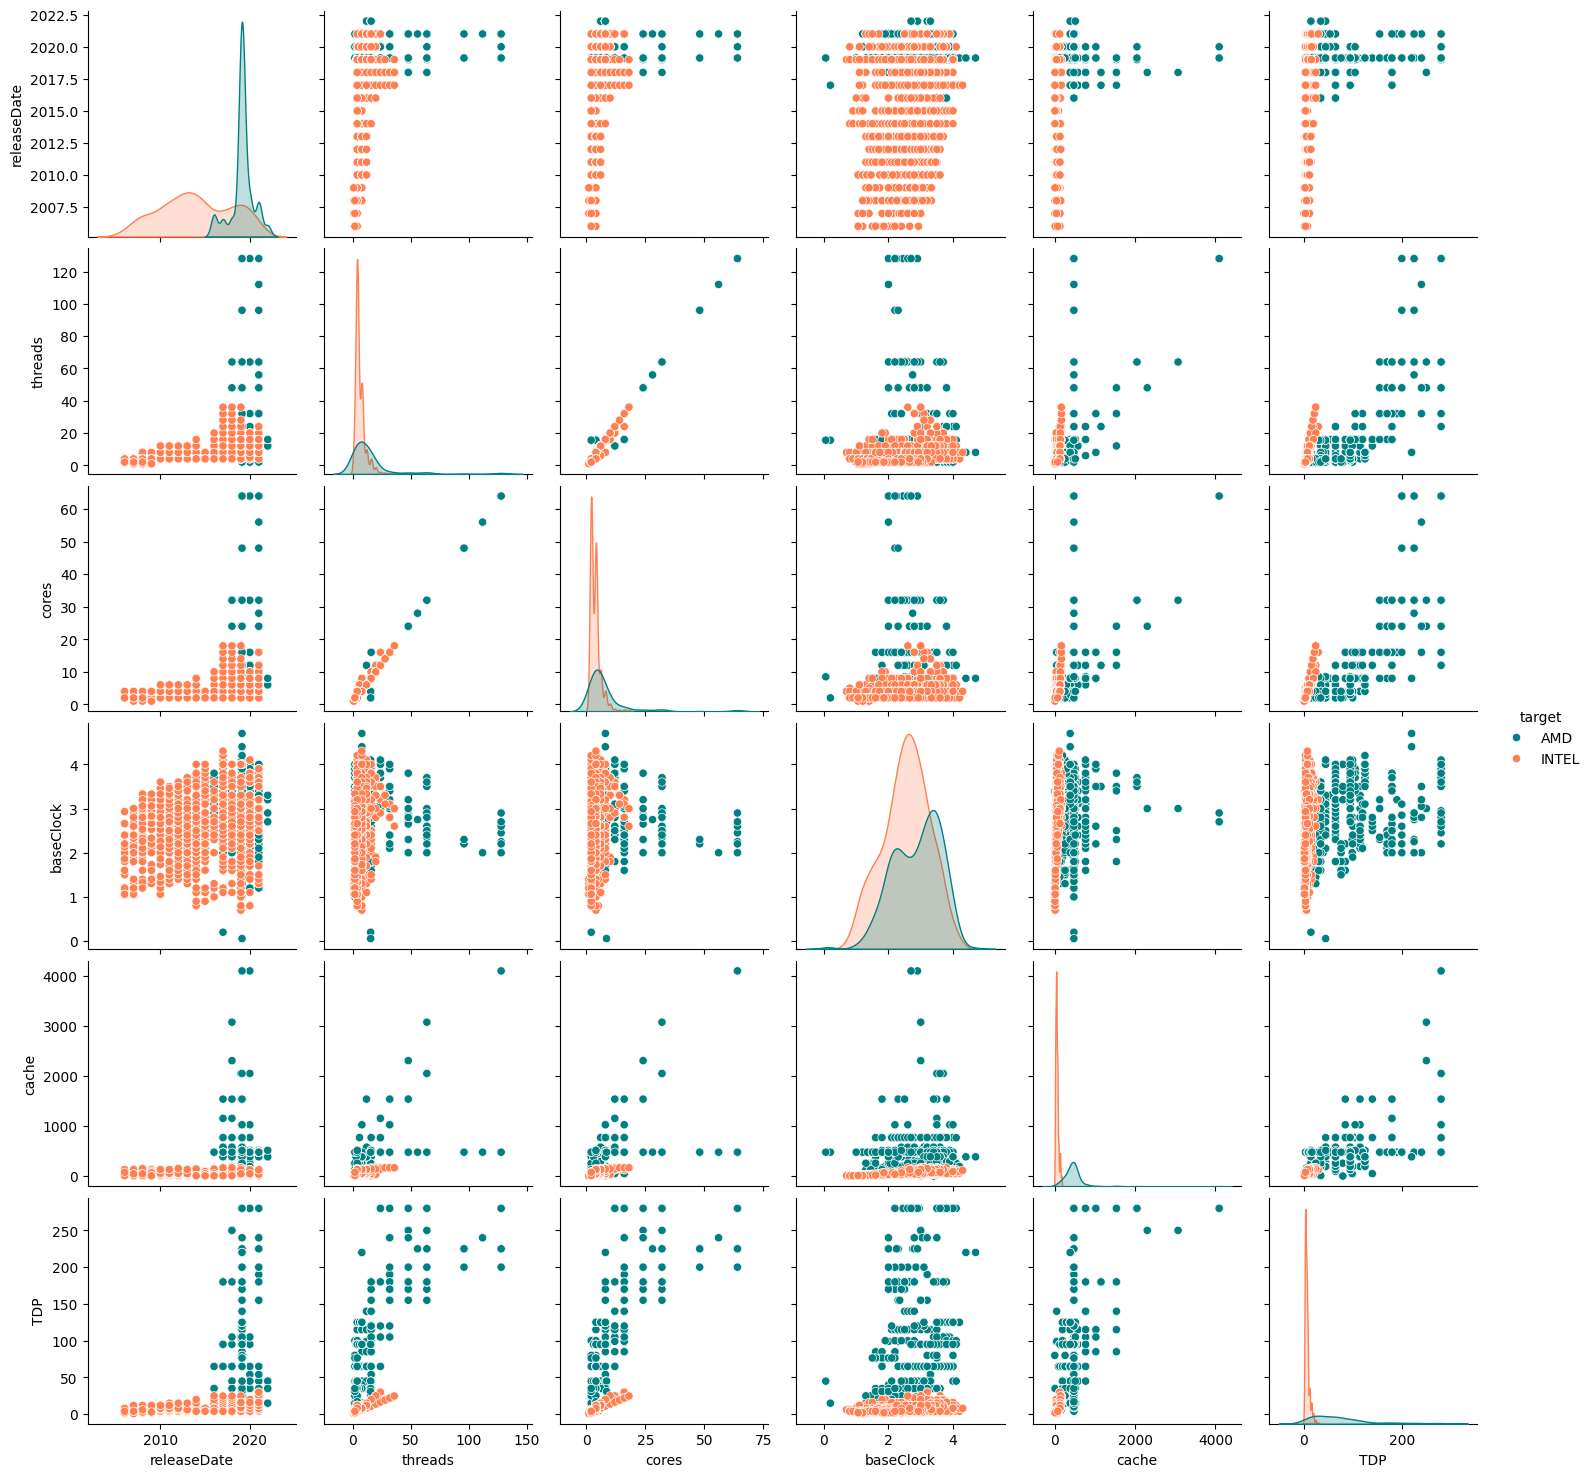

In [ ]:
sns.pairplot(merged, hue = 'target', palette = ['#008080', '#FF7F50'])

In [ ]:
merged.target = merged.target.map({"AMD":0 , "INTEL":1})

# mapping the target variable to 0 and 1

<ipython-input-181-7eea93ff713e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = merged.corr(method = 'spearman')


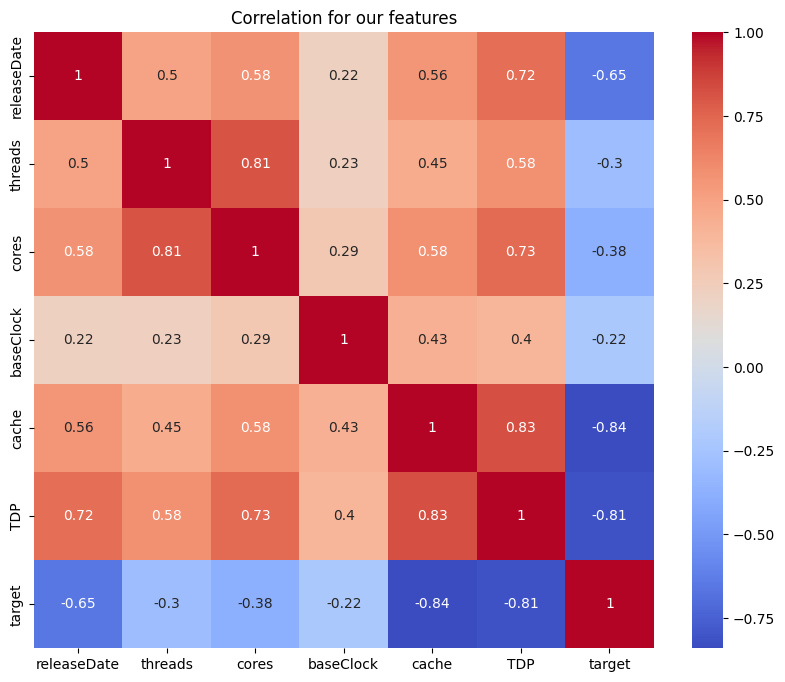

In [ ]:
correlation = merged.corr(method = 'spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation for our features')
plt.show()

# Training Models on the Merged Data

In [ ]:
X = merged.drop(['target'], axis = 1)
y = merged.target


Dropping the target variable involves removing the column containing the variable that the model aims to predict from the dataset, so the model would not learn it during training

### Preprocessing the Features

In [ ]:
le = LabelEncoder()
X['product'] = le.fit_transform(X['product'])

 It assigns a unique integer to each category, making it easier for algorithms to process categorical data.

In [ ]:
scaler = StandardScaler()
X[['threads', 'cores', 'baseClock','cache','TDP']] = scaler.fit_transform(X[['threads', 'cores', 'baseClock','cache','TDP']])

It scales features to have a mean of zero and a standard deviation of one, ensuring all features have the same scale. This helps algorithms converge faster and avoids certain features dominating the mode

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 42) # 70% for training and 30% for testing

The model is trained on the larger training set(70%) and evaluated on the smaller test set(30%)

In [ ]:
def get_evals(preds):
  print('ACCURACY SCORE:', metrics.accuracy_score(y_test,preds))
  print('F1 SCORE:', metrics.f1_score(y_test,preds))
  print('AUC SCORE:', metrics.roc_auc_score(y_test,preds))



def plot_confusion_matrix(y_test, preds, labels=["AMD", "INTEL"]):
    # we map the integers back to labels
    label_map = {0: "AMD", 1: "INTEL"}
    y_test_int = [label_map[label] for label in y_test]
    preds_int = [label_map[label] for label in preds]

    cm = confusion_matrix(y_test_int, preds_int)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_auc_curve(y_test, preds):
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

The above are helper functions , mostly for plotting

### Support Vector Machines (SVM)

In [ ]:
svm = SVC()
svm.fit(X_train,y_train)
svm_preds = svm.predict(X_test)
get_evals(svm_preds)

ACCURACY SCORE: 0.9541284403669725
F1 SCORE: 0.963235294117647
AUC SCORE: 0.942528735632184


**Accuracy:**
Accuracy measures the proportion of correctly classified instances out of the total instances in a dataset

**F1 Score:**. F1 score is the harmonic mean of precision and recall, providing a balance between them.

$$F1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$$

**ROC-AUC**:  ROC AUC (Receiver Operating Characteristic Area Under the Curve) evaluates the performance of a binary classification model across all classification thresholds.

$$AUC = \int_{0}^{1} TPR(t) \, dFPR(t)$$

-  TPR stands for True Positive Rate (also known as Sensitivity or Recall).
-  FPR stands for False Positive Rate.
- Integration is taken over the entire range of possible threshold values, typically from 0 to 1.

In [ ]:
pprint(metrics.classification_report(y_test,svm_preds))

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      0.89      0.94       174\n'
 '           1       0.93      1.00      0.96       262\n'
 '\n'
 '    accuracy                           0.95       436\n'
 '   macro avg       0.96      0.94      0.95       436\n'
 'weighted avg       0.96      0.95      0.95       436\n')


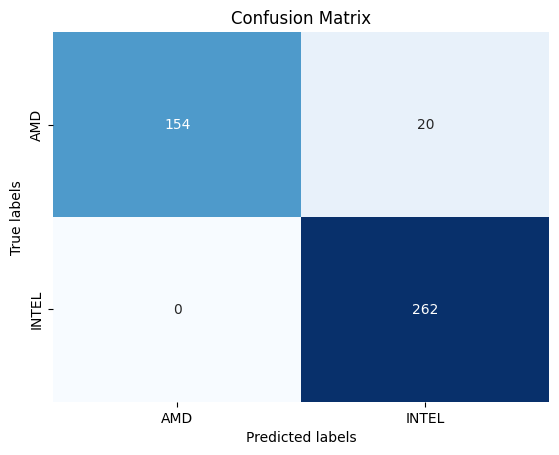

In [ ]:
plot_confusion_matrix(y_test,svm_preds)

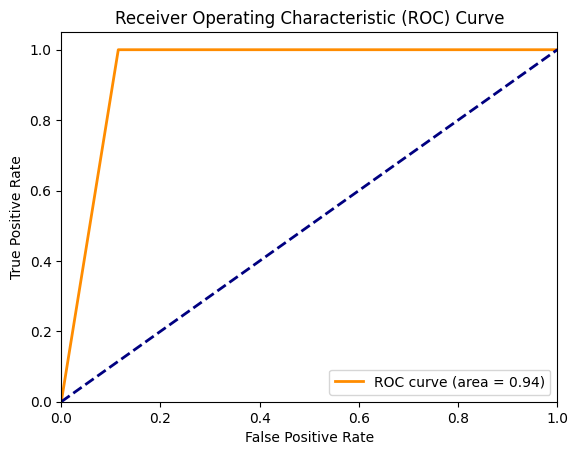

In [ ]:
plot_roc_auc_curve(y_test,svm_preds)